In [1]:
## research paper used  -> https://arxiv.org/pdf/2103.00020 ,https://arxiv.org/html/2406.03865v1 (used this to get an idea of semantic similarity)


## CLIP

In [1]:
import requests
import torch
import torchvision
from torchvision  import datasets,transforms
from torchvision.transforms import ToTensor
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", dtype=torch.float16, attn_implementation="sdpa")
processor =CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32",use_fast=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [3]:
import matplotlib.pyplot as plt

## Exp 1 (CIFAR SET)

In [4]:

train_dataset=torchvision.datasets.CIFAR10('data',train=True,download=True,target_transform=None,transform=None)


In [5]:
len(train_dataset)

50000

In [6]:
classes=train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
img,label_idx=train_dataset[2]
label=classes[label_idx]


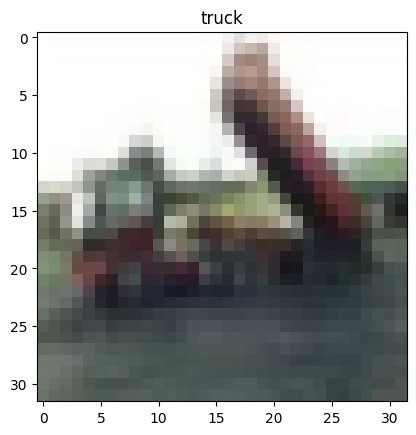

In [9]:
plt.title(label)
plt.imshow(img)

In [10]:
text_prompt = [f"a photo of a {label}" for label in classes]
inputs = processor(
    text=text_prompt,
    images=[img],
    return_tensors="pt",
    padding=True
)



### Similarity score between cat and dog

In [11]:
dataset_a_images=[] # dog
dataset_b_images=[] # cat
dataset_c_images=[] #truck
dataset_d_images=[] #ship

for (img,label) in train_dataset:
  if label==5:
    dataset_a_images.append(img)
  elif label==3:
    dataset_b_images.append(img)
  elif label==9:
    dataset_c_images.append(img)
  elif label==8:
    dataset_d_images.append(img)


In [12]:
image_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),

])



In [2]:
def custom_collate_pil(batch):
  images = []
  for item in batch:
     img=item
     images.append(img)


  return images

In [14]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
  def __init__(self,images):
    self.images=images

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    return self.images[idx]

dog_dataset=ImageDataset(dataset_a_images)
cat_dataset=ImageDataset(dataset_b_images)
truck_dataset=ImageDataset(dataset_c_images)
ship_dataset=ImageDataset(dataset_d_images)

dog_loader = DataLoader(dog_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_pil)
cat_loader = DataLoader(cat_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_pil)
truck_loader = DataLoader(truck_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_pil)
ship_loader = DataLoader(ship_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_pil)

In [15]:
def extract_embeddings(dataloader,model,processor,device):
  all_embeddings=[]
  model.eval()

  with torch.no_grad():
    for images_batch in dataloader:

            inputs = processor(
                images=images_batch,
                return_tensors="pt"
            ).to(device)


            image_features = model.get_image_features(**inputs)


            all_embeddings.append(image_features.cpu())

    return torch.cat(all_embeddings, dim=0)


In [16]:
dog_embeddings=extract_embeddings(dog_loader,model,processor,device)
cat_embeddings=extract_embeddings(cat_loader,model,processor,device)
truck_embeddings=extract_embeddings(truck_loader,model,processor,device)
ship_embeddings=extract_embeddings(ship_loader,model,processor,device)

### Similarity scores  


#### CAT VS DOG

#### Centroid Cosine similarity

In [17]:
import torch.nn.functional as F
dog_embeddings_cpy=dog_embeddings
cat_embeddings_cpy=cat_embeddings
dog_mean=torch.mean(dog_embeddings,dim=0)  # shape [512]
cat_mean=torch.mean(cat_embeddings,dim=0)  # shape [512]

cosine_similarity_score=F.cosine_similarity(    # we unsqueze because 2d vector is exprected so we get  -> [1,512]
    dog_mean.unsqueeze(0),
    cat_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity (Dog vs. Cat): {cosine_similarity_score.item():.4f}")


Centroid Cosine Similarity (Dog vs. Cat): 0.9785


#### Fréchet Embedding Distance

In [14]:
import numpy as np
from scipy.linalg import sqrtm

In [3]:
def calculate_fed(embedding1,embedding2):
  embedding1 = embedding1.cpu().numpy()
  embedding2 = embedding2.cpu().numpy()
  mean_1,cov_1=np.mean(embedding1,axis=1),np.cov(embedding1)
  mean_2,cov_2=np.mean(embedding2,axis=1),np.cov(embedding2)

  squared_diff_mean=np.sum((mean_1-mean_2)**2)
  eps = 1e-6
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)

    # Matrix square root might return complex numbers, take the real part
  if np.iscomplexobj(covmean):
        covmean = covmean.real

  fed=squared_diff_mean+np.trace(cov_1+cov_2-2.0*covmean)
  fed=max(0,fed)
  return fed

In [20]:
fed_score = calculate_fed(cat_embeddings_cpy, dog_embeddings_cpy)
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

/tmp/ipython-input-1256775283.py:9: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)


Fréchet Embedding Distance: 347.6880


#### DOG VS TRUCK

#### Centroid Cosine similarity

In [21]:
import torch.nn.functional as F

dog_mean=torch.mean(dog_embeddings,dim=0)  # shape [512]
truck_mean=torch.mean(truck_embeddings,dim=0)  # shape [512]

cosine_similarity_score=F.cosine_similarity(    # we unsqueze because 2d vector is exprected so we get  -> [1,512]
    dog_mean.unsqueeze(0),
    truck_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity (Dog vs. Truck): {cosine_similarity_score.item():.4f}")


Centroid Cosine Similarity (Dog vs. Truck): 0.8545


#### Frechet embedding distance

In [22]:
fed_score = calculate_fed(truck_embeddings, dog_embeddings)
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

/tmp/ipython-input-1256775283.py:9: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)


Fréchet Embedding Distance: 370.8711


#### TRUCK VS SHIP

#### Centroid cosine similarity

In [23]:
import torch.nn.functional as F

ship_mean=torch.mean(ship_embeddings,dim=0)  # shape [512]
truck_mean=torch.mean(truck_embeddings,dim=0)  # shape [512]

cosine_similarity_score=F.cosine_similarity(    # we unsqueze because 2d vector is exprected so we get  -> [1,512]
    ship_mean.unsqueeze(0),
    truck_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity (Ship vs. Truck): {cosine_similarity_score.item():.4f}")


Centroid Cosine Similarity (Ship vs. Truck): 0.9106


#### Frechet embedding distance

In [24]:
fed_score = calculate_fed(truck_embeddings, ship_embeddings)
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

/tmp/ipython-input-1256775283.py:9: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)


Fréchet Embedding Distance: 379.1478


## EXP_2 (CIFAKE)

In [4]:
import zipfile
import os


zip_file_path = '/content/archive (2).zip'


extract_directory = '/content/extracted_data'

os.makedirs(extract_directory, exist_ok=True)


try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_directory)
    print(f"Successfully extracted '{os.path.basename(zip_file_path)}' to '{extract_directory}'")
except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_file_path}'. Please check the path.")
except zipfile.BadZipFile:
    print(f"Error: The file at '{zip_file_path}' is not a valid zip file or is corrupted.")

Successfully extracted 'archive (2).zip' to '/content/extracted_data'


In [4]:
import os

test_fake_path="/content/extracted_data/test/FAKE"
test_real_path="/content/extracted_data/test/REAL"
train_fake_path="/content/extracted_data/train/FAKE"
train_real_path="/content/extracted_data/train/REAL"
test_fake_imgs=[f"{test_fake_path}/{filename}" for filename in os.listdir(test_fake_path)]
test_real_imgs=[f"{test_real_path}/{filename}"for filename in os.listdir(test_real_path)]
train_fake_imgs=[f"{train_fake_path}/{filename}" for filename in os.listdir(train_fake_path)]
train_real_imgs=[f"{train_real_path}/{filename}"for filename in os.listdir(train_real_path)]


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import requests
import torchvision
from torchvision  import datasets,transforms
from torchvision.transforms import ToTensor
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self,images):
    self.images=images

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    return self.images[idx]


In [6]:
train_fake_dataset=ImageDataset(train_fake_imgs)
train_real_dataset=ImageDataset(train_real_imgs)
test_fake_dataset=ImageDataset(test_fake_imgs)
test_real_dataset=ImageDataset(test_real_imgs)

In [7]:

train_fake_loader = DataLoader(train_fake_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_pil)
train_real_loader = DataLoader(train_real_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_pil)
test_fake_loader = DataLoader(test_fake_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_pil)
test_real_loader = DataLoader(test_real_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_pil)

In [8]:
def extract_embeddings(dataloader,model,processor,device):
  all_embeddings=[]
  model.eval()

  with torch.no_grad():
    for images_batch in dataloader:

            inputs = processor(
                images=images_batch,
                return_tensors="pt"
            ).to(device)


            image_features = model.get_image_features(**inputs)


            all_embeddings.append(image_features.cpu())

    # Concatenate all batches into one big tensor
    # The shape will be [num_images, embedding_dim] (e.g., [5000, 512])
    return torch.cat(all_embeddings, dim=0)


In [9]:
train_fake_embeddings=extract_embeddings(train_fake_loader,model,processor,device)
test_fake_embeddings=extract_embeddings(test_fake_loader,model,processor,device)
train_real_embeddings=extract_embeddings(train_real_loader,model,processor,device)
test_real_embeddings=extract_embeddings(test_real_loader,model,processor,device)

## Similarity score

#### TRAIN ->  REAL VS FAKE

#### Centroid Cosine similarity

In [18]:
import torch.nn.functional as F

train_real_mean=torch.mean(train_real_embeddings,dim=0)
train_fake_mean=torch.mean(train_fake_embeddings,dim=0)

cosine_similarity_score=F.cosine_similarity(
    train_real_mean.unsqueeze(0),
    train_fake_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity: {cosine_similarity_score.item():.4f}")


Centroid Cosine Similarity: 0.9912


#### Fréchet Embedding Distance

In [12]:
import numpy as np

In [11]:
len(train_real_embeddings)

50000

In [15]:
fed_score = calculate_fed(train_real_embeddings[:2000], train_fake_embeddings[:2000])
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

/tmp/ipython-input-1256775283.py:9: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)


Fréchet Embedding Distance: 170.8972


#### TEST -> REAL VS FAKE

#### Centroid Cosine similarity

In [10]:
import torch.nn.functional as F

test_fake_mean=torch.mean(test_fake_embeddings,dim=0)
test_real_mean=torch.mean(test_real_embeddings,dim=0)

cosine_similarity_score=F.cosine_similarity(
    test_real_mean.unsqueeze(0),
    test_fake_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity : {cosine_similarity_score.item():.4f}")


Centroid Cosine Similarity : 0.9912


#### Fréchet Embedding Distance

In [17]:
fed_score = calculate_fed(test_real_embeddings[:2000], test_fake_embeddings[:2000])
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

/tmp/ipython-input-1256775283.py:9: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)


Fréchet Embedding Distance: 169.3946
